
--- Visualizando TODOS los Canales para Tensor Individual: 003_S_4354 ---
Cargando tensor desde: /home/diego/Escritorio/AAL3/AAL3_131ROIs_fmri_tensor_OMST_GCE_Signed_GrangerLag1_NeuroEnhanced_v6.5.9_ParallelTuned/individual_subject_tensors/tensor_6ch_131rois_003_S_4354.npz
  Claves encontradas en el archivo .npz: ['tensor_data', 'subject_id', 'channel_names', 'rois_count', 'target_len_ts']
  Tensor individual detectado. Forma: (6, 131, 131)
  Sujeto: 003_S_4354, Canales: 6, ROIs: 131
Seleccionando todos los 6 canales disponibles.

--- Procesando Canal: Pearson_OMST_GCE_Signed_Weighted (Índice: 0) ---


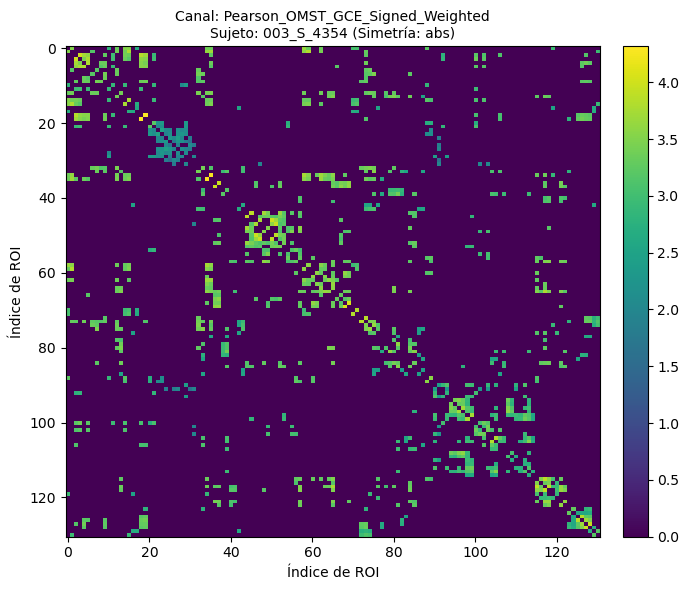

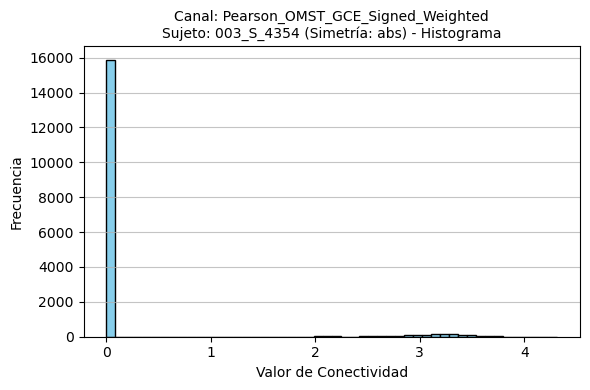


--- Procesando Canal: Pearson_Full_FisherZ_Signed (Índice: 1) ---


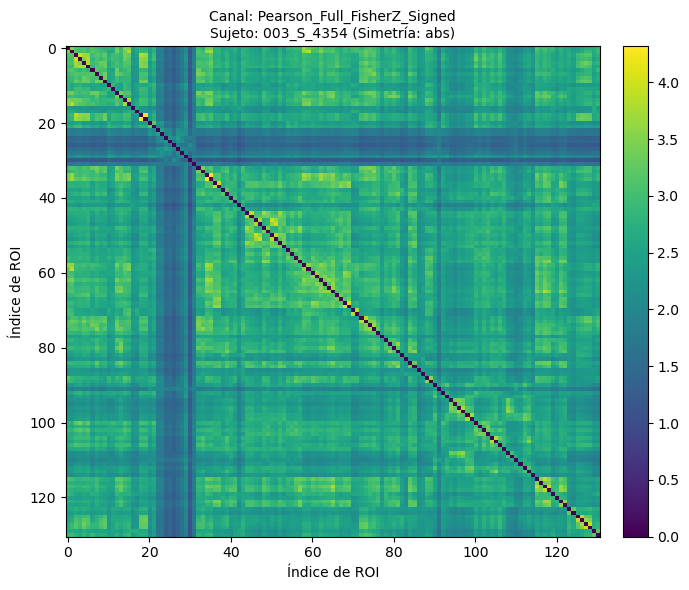

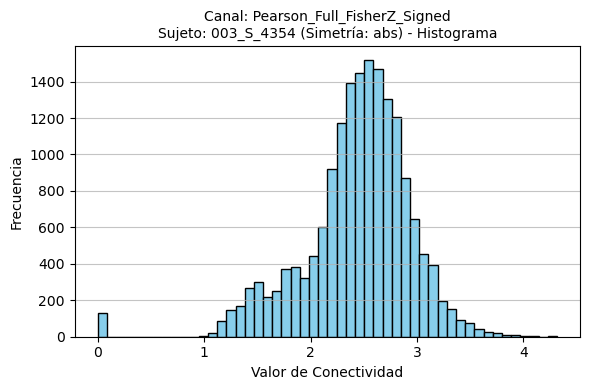


--- Procesando Canal: MI_KNN_Symmetric (Índice: 2) ---


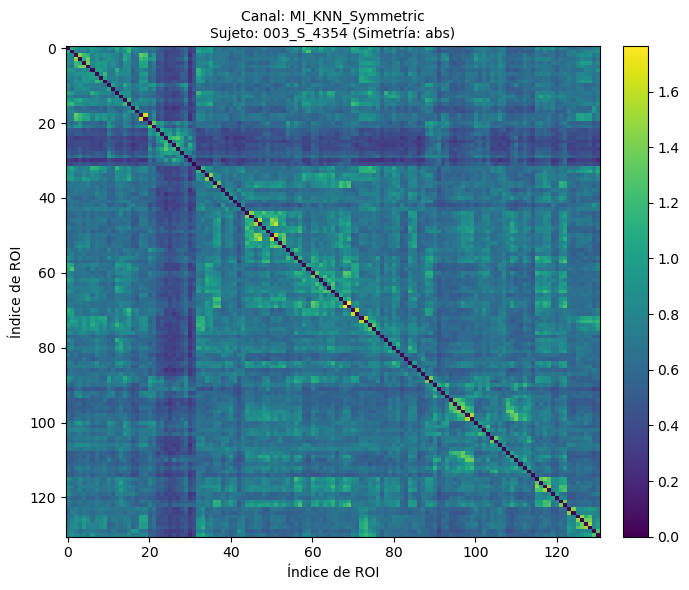

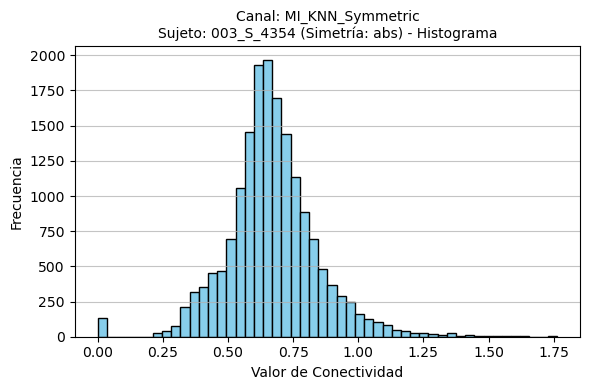


--- Procesando Canal: dFC_AbsDiffMean (Índice: 3) ---


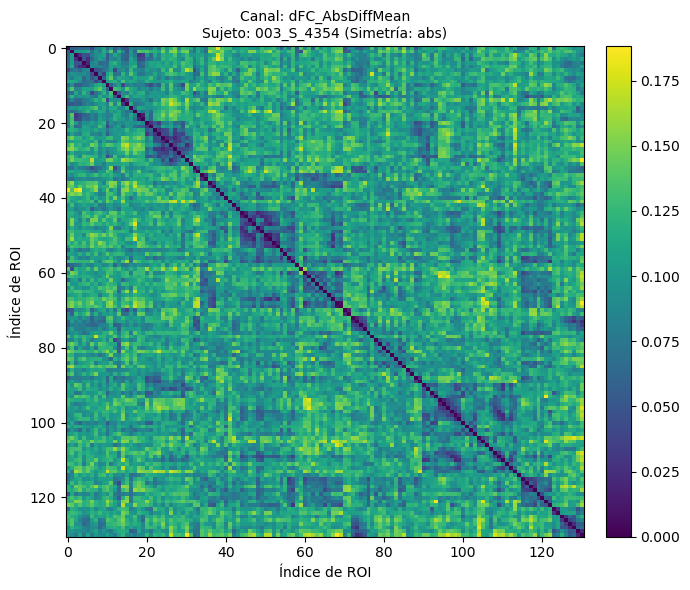

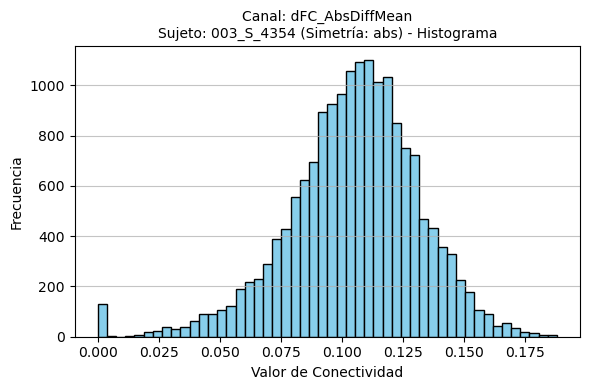


--- Procesando Canal: dFC_StdDev (Índice: 4) ---


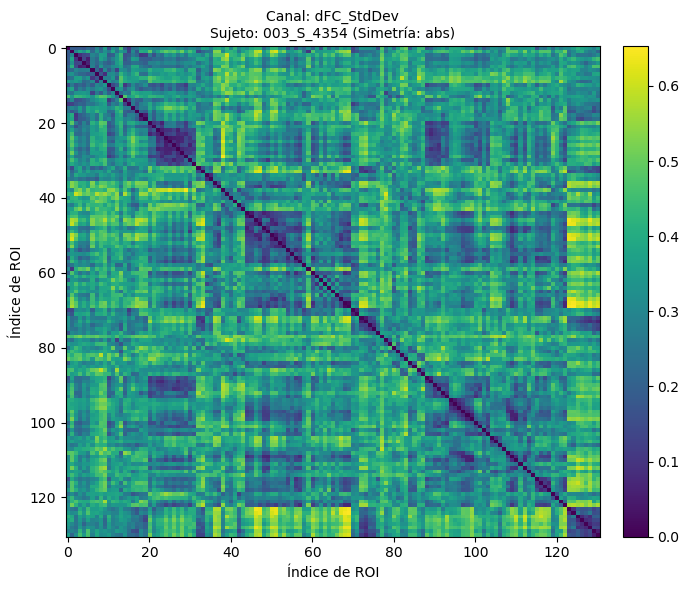

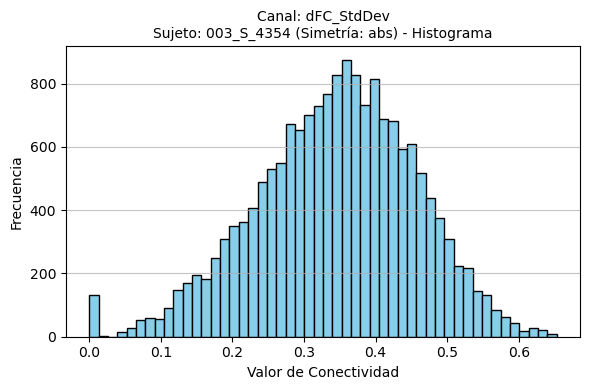


--- Procesando Canal: Granger_F_lag1 (Índice: 5) ---


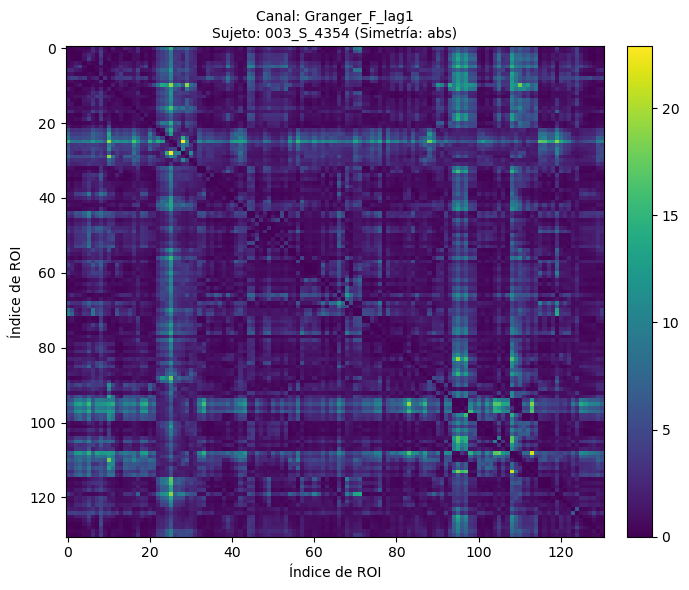

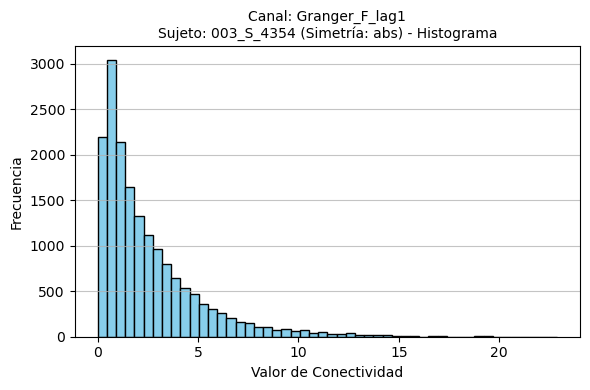

Archivo no encontrado: /home/diego/Escritorio/AAL3/AAL3_131ROIs_fmri_tensor_OMST_GCE_Signed_GrangerLag1_NeuroEnhanced_v6.5.9_ParallelTuned/individual_subject_tensors/tensor_4ch_131rois_002_S_1155.npz


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Utilitario para Jupyter Notebook:
1. Cargar un tensor de conectividad (.npz) – individual o global –
2. Inspeccionar su metadata (nº sujetos, canales, ROIs, etc.)
3. Visualizar rápidamente:
    • La matriz de conectividad de un sujeto y canal específico (o todos)
    • La matriz promedio (entre sujetos) por canal
    • Histogramas de valores (para QC rápida)

Adaptado para correr en una celda de notebook.
"""
import sys
from pathlib import Path
from typing import Optional, Dict, Any, Tuple, List, Union # Añadido Union
import numpy as np
import matplotlib.pyplot as plt

# ------- utilidades auxiliares ---------

def load_npz_tensor(npz_path: Path) -> Tuple[np.ndarray, Dict[str, Any]]:
    """Carga el .npz y devuelve tensor + metadatos."""
    if not npz_path.exists():
        raise FileNotFoundError(f"Archivo de tensor no encontrado: {npz_path}")
    
    print(f"Cargando tensor desde: {npz_path}")
    data = np.load(npz_path, allow_pickle=True)
    keys = list(data.keys())
    print(f"  Claves encontradas en el archivo .npz: {keys}")

    tensor: np.ndarray
    meta: Dict[str, Any]

    if 'global_tensor_data' in keys:
        tensor = data['global_tensor_data']
        meta = {
            'subject_ids': data['subject_ids'] if 'subject_ids' in keys else ["Unknown_Global_Subject_IDs"],
            'channel_names': data['channel_names'] if 'channel_names' in keys else [f"Ch{i}" for i in range(tensor.shape[1])],
            'rois_count': int(data['rois_count']) if 'rois_count' in keys else tensor.shape[-1],
            'type': 'global'
        }
        print(f"  Tensor global detectado. Forma: {tensor.shape}")
        print(f"  Sujetos: {len(meta['subject_ids']) if meta['subject_ids'] is not None else 'N/A'}, Canales: {len(meta['channel_names'])}, ROIs: {meta['rois_count']}")
    elif 'tensor_data' in keys:
        tensor = data['tensor_data']
        meta = {
            'subject_ids': np.array([data['subject_id']]) if 'subject_id' in keys else ["Unknown_Individual_Subject_ID"],
            'channel_names': data['channel_names'] if 'channel_names' in keys else [f"Ch{i}" for i in range(tensor.shape[0])],
            'rois_count': int(data['rois_count']) if 'rois_count' in keys else tensor.shape[-1],
            'type': 'individual'
        }
        print(f"  Tensor individual detectado. Forma: {tensor.shape}")
        print(f"  Sujeto: {meta['subject_ids'][0]}, Canales: {len(meta['channel_names'])}, ROIs: {meta['rois_count']}")
    else:
        raise ValueError("Estructura NPZ no soportada – se esperaba 'global_tensor_data' o 'tensor_data'.")
    
    if meta['type'] == 'individual':
        if not (tensor.ndim == 3 and tensor.shape[1] == tensor.shape[2] and tensor.shape[1] == meta['rois_count']):
            print(f"Advertencia: La forma del tensor individual {tensor.shape} o rois_count {meta['rois_count']} podría no ser la esperada (Canales, ROIs, ROIs).")
    elif meta['type'] == 'global':
        if not (tensor.ndim == 4 and tensor.shape[2] == tensor.shape[3] and tensor.shape[2] == meta['rois_count']):
            print(f"Advertencia: La forma del tensor global {tensor.shape} o rois_count {meta['rois_count']} podría no ser la esperada (Sujetos, Canales, ROIs, ROIs).")

    return tensor, meta


def pick_channel_indices(channel_arg: Union[str, int, List[Union[str, int]], None], 
                         channel_names: np.ndarray) -> List[int]:
    """Devuelve una lista de índices de canales. Si channel_arg es 'all' o None, devuelve todos."""
    channel_names_list = [str(name) for name in channel_names]
    
    if channel_arg is None or (isinstance(channel_arg, str) and channel_arg.lower() == 'all'):
        print(f"Seleccionando todos los {len(channel_names_list)} canales disponibles.")
        return list(range(len(channel_names_list)))

    if not isinstance(channel_arg, list):
        channels_to_process = [channel_arg]
    else:
        channels_to_process = channel_arg
    
    indices = []
    for ch_ref in channels_to_process:
        try:
            idx = int(ch_ref)
            if not (0 <= idx < len(channel_names_list)):
                raise IndexError(f"Índice de canal {idx} fuera de rango (0-{len(channel_names_list)-1}).")
            print(f"Canal seleccionado por índice: {idx} ('{channel_names_list[idx]}')")
            indices.append(idx)
        except ValueError: 
            try:
                idx = channel_names_list.index(str(ch_ref))
                print(f"Canal seleccionado por nombre: '{ch_ref}' (índice {idx})")
                indices.append(idx)
            except ValueError:
                raise ValueError(f"Nombre de canal '{ch_ref}' no encontrado. Opciones disponibles: {channel_names_list}")
        except IndexError as e: 
            raise e
    return sorted(list(set(indices))) # Devuelve índices únicos y ordenados


def symmetrize(mat: np.ndarray, mode: str) -> np.ndarray:
    """Aplica un tratamiento de simetría para visualización."""
    if mode == 'abs':
        return np.abs(mat)
    if mode == 'upper':
        tri = np.triu(mat) 
        return tri + tri.T - np.diag(np.diag(mat)) 
    return mat


def plot_matrix(matrix: np.ndarray, title: str, save_fig: Optional[Path]):
    """Visualiza una matriz de conectividad."""
    fig, ax = plt.subplots(figsize=(7, 6)) 
    im = ax.imshow(matrix, aspect='auto', cmap='viridis') 
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Índice de ROI')
    ax.set_ylabel('Índice de ROI')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    if save_fig:
        try:
            fig.savefig(save_fig, dpi=300)
            print(f"Figura guardada en: {save_fig}")
        except Exception as e:
            print(f"Error al guardar la figura {save_fig}: {e}")
    else:
        plt.show()


def plot_hist(values: np.ndarray, title: str, save_fig: Optional[Path]):
    """Visualiza un histograma de los valores de la matriz."""
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(values.flatten(), bins=50, color='skyblue', edgecolor='black')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Valor de Conectividad')
    ax.set_ylabel('Frecuencia')
    ax.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    if save_fig:
        try:
            fig.savefig(save_fig, dpi=300)
            print(f"Histograma guardado en: {save_fig}")
        except Exception as e:
            print(f"Error al guardar el histograma {save_fig}: {e}")
    else:
        plt.show()

# ------- Función principal para Notebook -------------

def visualize_tensor_data(
    tensor_path_str: str, 
    channel_to_show: Union[str, int, List[Union[str, int]], None], # Puede ser 'all', un nombre, un índice o una lista
    subject_id_or_index: str = "0", 
    show_average: bool = False, 
    symmetrize_mode: str = 'abs', 
    save_figure_prefix: Optional[str] = None
):
    """
    Función principal para cargar, procesar y visualizar un tensor de conectividad
    en un entorno de Jupyter Notebook.
    Si channel_to_show es 'all' o None, se visualizarán todos los canales.
    """
    tensor_path = Path(tensor_path_str)

    try:
        tensor, meta = load_npz_tensor(tensor_path)
        
        channel_indices_to_plot = pick_channel_indices(channel_to_show, meta['channel_names'])

        for ch_idx in channel_indices_to_plot:
            channel_name_selected = meta['channel_names'][ch_idx]
            print(f"\n--- Procesando Canal: {channel_name_selected} (Índice: {ch_idx}) ---")

            matrix_to_plot: Optional[np.ndarray] = None
            subject_label_for_title: str = ""

            if meta['type'] == 'individual':
                if tensor.ndim == 3 and tensor.shape[0] == len(meta['channel_names']):
                    matrix_to_plot = tensor[ch_idx, :, :]
                    subject_label_for_title = str(meta['subject_ids'][0])
                else:
                    print(f"Advertencia: Tensor individual con forma inesperada: {tensor.shape}. Esperado (Canales, ROIs, ROIs). Saltando canal {channel_name_selected}.")
                    continue
                if show_average:
                    print("Advertencia: 'show_average' se especificó para un tensor individual. Se mostrará el único sujeto.")

            elif meta['type'] == 'global':
                if show_average:
                    if tensor.ndim == 4 and tensor.shape[1] == len(meta['channel_names']):
                        matrix_to_plot = np.mean(tensor[:, ch_idx, :, :], axis=0)
                        subject_label_for_title = f"Promedio de {tensor.shape[0]} sujetos"
                    else:
                        print(f"Advertencia: Tensor global con forma inesperada para promedio: {tensor.shape}. Esperado (Sujetos, Canales, ROIs, ROIs). Saltando canal {channel_name_selected}.")
                        continue
                else: 
                    num_subjects_global = tensor.shape[0]
                    current_subject_id_or_idx_str = subject_id_or_index
                    
                    try:
                        subj_idx = list(meta['subject_ids']).index(current_subject_id_or_idx_str)
                        print(f"Sujeto encontrado por ID: '{current_subject_id_or_idx_str}' en el índice {subj_idx}.")
                    except ValueError: 
                        try:
                            subj_idx = int(current_subject_id_or_idx_str)
                            if not (0 <= subj_idx < num_subjects_global):
                                raise IndexError(f"Índice de sujeto {subj_idx} fuera de rango (0 a {num_subjects_global - 1}).")
                            print(f"Sujeto seleccionado por índice: {subj_idx} ('{meta['subject_ids'][subj_idx]}').")
                        except ValueError:
                            raise ValueError(f"Argumento de sujeto '{current_subject_id_or_idx_str}' no es un ID válido ni un índice numérico para el tensor global.")
                    
                    subject_label_for_title = str(meta['subject_ids'][subj_idx])
                    if tensor.ndim == 4 and tensor.shape[1] == len(meta['channel_names']):
                        matrix_to_plot = tensor[subj_idx, ch_idx, :, :]
                    else:
                        print(f"Advertencia: Tensor global con forma inesperada para selección de sujeto: {tensor.shape}. Esperado (Sujetos, Canales, ROIs, ROIs). Saltando canal {channel_name_selected}.")
                        continue
            
            if matrix_to_plot is None:
                print(f"Advertencia: No se pudo determinar la matriz a graficar para el canal {channel_name_selected}. Saltando.")
                continue

            matrix_processed = symmetrize(matrix_to_plot, symmetrize_mode)
            
            base_title = f"Canal: {channel_name_selected}\nSujeto: {subject_label_for_title} (Simetría: {symmetrize_mode})"
            
            current_save_path_matrix = None
            current_save_path_hist = None
            if save_figure_prefix:
                prefix_path = Path(save_figure_prefix)
                prefix_path.parent.mkdir(parents=True, exist_ok=True) 
                # Añadir nombre del canal al prefijo para evitar sobrescribir
                fig_file_stem = f"{prefix_path.name}_{channel_name_selected.replace(' ', '_').replace('/', '_')}"
                current_save_path_matrix = prefix_path.with_name(fig_file_stem + "_matrix.png")
                current_save_path_hist = prefix_path.with_name(fig_file_stem + "_hist.png")

            plot_matrix(matrix_processed, base_title, current_save_path_matrix)
            plot_hist(matrix_processed, base_title + " - Histograma", current_save_path_hist)

    except FileNotFoundError as e:
        print(f"Error: {e}", file=sys.stderr)
    except (ValueError, IndexError) as e:
        print(f"Error de configuración o datos: {e}", file=sys.stderr)
    except Exception as e:
        print(f"Ocurrió un error inesperado: {e}", file=sys.stderr)

# --- EJEMPLOS DE USO EN UN NOTEBOOK ---
# Descomenta y ajusta las siguientes líneas para probar:

# Directorio base donde se guardan los tensores individuales (ajusta esta ruta)
# Asegúrate de que esta ruta sea correcta para tu sistema y la salida de tu pipeline.
# El nombre del directorio puede variar ligeramente (ej. v6.5 vs v6.4_Robust)
INDIVIDUAL_TENSORS_BASE_DIR = Path(
    "/home/diego/Escritorio/AAL3/AAL3_131ROIs_fmri_tensor_OMST_GCE_Signed_GrangerLag1_NeuroEnhanced_v6.5.9_ParallelTuned/individual_subject_tensors"
)
#INDIVIDUAL_TENSORS_BASE_DIR = Path("/home/diego/Escritorio/AAL3/AAL3_131ROIs_fmri_tensor_OMST_GCE_1lag_NeuroEnhanced_v6.5/individual_subject_tensors") # Ejemplo
# NOMBRE_ARCHIVO_TENSOR_GLOBAL = Path("/home/diego/Escritorio/AAL3/AAL3_131ROIs_fmri_tensor_OMST_GCE_1lag_NeuroEnhanced_v6.5/GLOBAL_TENSOR_AAL3_131ROIs_434subs_4ch_1lag.npz") # Ejemplo


# --- Ejemplo 1: Visualizar TODOS los canales de un sujeto individual ---
subject_id_to_check = "003_S_4354"
# Asumiendo que el nombre de archivo es consistente con tu pipeline (4 canales, 131 ROIs)
#file_name_individual = f"tensor_4ch_131rois_{subject_id_to_check}.npz" 
file_name_individual = f"tensor_6ch_131rois_{subject_id_to_check}.npz" # Asegúrate de que este nombre sea correcto
tensor_file_path_individual = INDIVIDUAL_TENSORS_BASE_DIR / file_name_individual

if tensor_file_path_individual.exists():
    print(f"\n--- Visualizando TODOS los Canales para Tensor Individual: {subject_id_to_check} ---")
    visualize_tensor_data(
        tensor_path_str=str(tensor_file_path_individual),
        channel_to_show="all", # Palabra clave para mostrar todos los canales
        # save_figure_prefix=f"plots_qc/{subject_id_to_check}_all_channels" # Opcional, guardará múltiples figuras
    )
else:
    print(f"Archivo no encontrado: {tensor_file_path_individual}")

# --- Ejemplo 2: Visualizar un canal específico de OTRO sujeto individual ---
subject_id_to_check_2 = "002_S_1155"
channel_to_check_2 = "MI_KNN_Symmetric" # o el índice 1
file_name_individual_2 = f"tensor_4ch_131rois_{subject_id_to_check_2}.npz"
tensor_file_path_individual_2 = INDIVIDUAL_TENSORS_BASE_DIR / file_name_individual_2

if tensor_file_path_individual_2.exists():
    print(f"\n--- Visualizando Tensor Individual: {subject_id_to_check_2}, Canal: {channel_to_check_2} ---")
    visualize_tensor_data(
        tensor_path_str=str(tensor_file_path_individual_2),
        channel_to_show=channel_to_check_2,
        symmetrize_mode='none'
    )
else:
    print(f"Archivo no encontrado: {tensor_file_path_individual_2}")

# --- Ejemplo 3: Visualizar el promedio de TODOS los sujetos para TODOS los canales del tensor GLOBAL ---
# (Asegúrate de que NOMBRE_ARCHIVO_TENSOR_GLOBAL apunte a tu archivo global)
# if NOMBRE_ARCHIVO_TENSOR_GLOBAL.exists():
#     print(f"\n--- Visualizando Promedio Global para TODOS los Canales ---")
#     visualize_tensor_data(
#         tensor_path_str=str(NOMBRE_ARCHIVO_TENSOR_GLOBAL),
#         channel_to_show="all", # Palabra clave para mostrar todos los canales
#         show_average=True
#         # save_figure_prefix=f"plots_qc/GLOBAL_AVG_all_channels" # Opcional
#     )
# else:
#     print(f"Archivo de tensor global no encontrado: {NOMBRE_ARCHIVO_TENSOR_GLOBAL}")

# --- Ejemplo 4: Visualizar TODOS los canales de un sujeto específico desde el tensor GLOBAL ---
# (Asegúrate de que NOMBRE_ARCHIVO_TENSOR_GLOBAL apunte a tu archivo global)
# if NOMBRE_ARCHIVO_TENSOR_GLOBAL.exists():
#     subject_to_show_from_global = "002_S_0685" # ID del sujeto
    
#     print(f"\n--- Visualizando TODOS los Canales para Sujeto {subject_to_show_from_global} desde Tensor Global ---")
#     visualize_tensor_data(
#         tensor_path_str=str(NOMBRE_ARCHIVO_TENSOR_GLOBAL),
#         channel_to_show="all", # Palabra clave para mostrar todos los canales
#         subject_id_or_index=subject_to_show_from_global 
#     )
# else:
#     print(f"Archivo de tensor global no encontrado: {NOMBRE_ARCHIVO_TENSOR_GLOBAL}")
